<a target="_blank" href="https://colab.research.google.com/github/ashkan-mokarian/d2l-pytorch/blob/main/chapter_rnn/1_markov_model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%pip install d2l==1.0.0a0

In [2]:
import torch
from d2l import torch as d2l

# Markov Model

## Synthetic sequence data

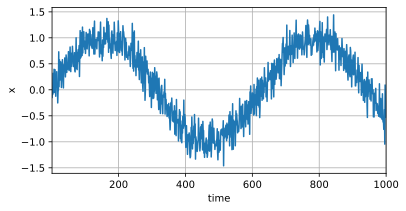

In [5]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        super().__init__()
        self.save_hyperparameters()
        self.time = torch.arange(1, T+1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [8]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    self.features = [self.x[i: self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(self.features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

batch_x, batch_y = next(iter(data.get_dataloader(True)))
batch_x.shape, batch_y.shape

(torch.Size([16, 4]), torch.Size([16, 1]))

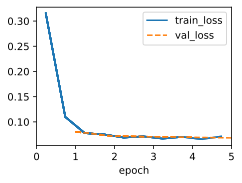

In [9]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

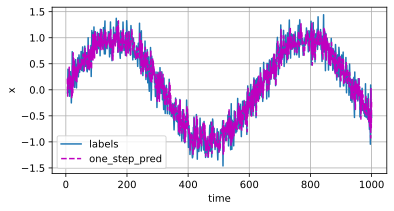

In [12]:
one_step_pred = model(data.features).detach()
d2l.plot(data.time[data.tau:], [data.labels, one_step_pred], 'time', 'x', legend=['labels', 'one_step_pred'], figsize=(6, 3))

## k-step ahead prediction
In the example above, we used the observed data to make ahead predictions. However, in realistic scenarios, we don't have observations beyond the train dataset and hence need to make use of the predicted values to condition fo predicting steps ahead.

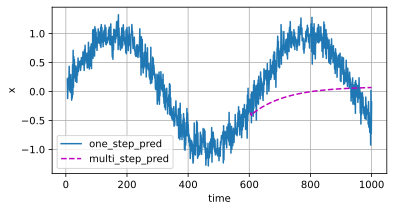

In [17]:
multi_step_pred = torch.zeros(data.T)
multi_step_pred[:] = data.x
for i in range(data.num_train+data.tau, data.T):
    multi_step_pred[i] = model(
        multi_step_pred[i-data.tau: i].reshape((1, -1))
        )
multi_step_pred = multi_step_pred.detach().numpy()
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [one_step_pred, multi_step_pred[data.num_train+data.tau:]],
         'time', 'x', legend=['one_step_pred', 'multi_step_pred'], figsize=(6, 3))

### Why?
why does the multi-step prediction diverge and result to this large error? This is because of cumulative errors. In the first prediction, we will have some error $ϵ_1=\bar{ϵ}$ and for the second we'll have $ϵ_1=\bar{ϵ} + cϵ_1$ and this cumulates over time.

### Experiment with predicting k-step ahead predictions

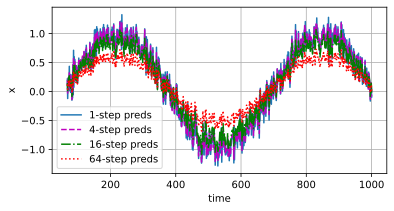

In [20]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # the (i+tau)-th element stores vaules for the (i+1)-step ahead predictions
    for i in range(k):
        pred = model(torch.stack(features[i : i+data.tau], 1))
        features.append(pred.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k-1].detach().numpy() for k in steps],
         'time', 'x', legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

As seen above, with higher ahead step predictions, the predictions get useless.